## Try to replicate SMT

In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from tools import *


# Check that MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is enabled!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda is enabled!")

!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

MPS is enabled!
MPS is enabled!


### 1. Generate data from Archimedean spiral

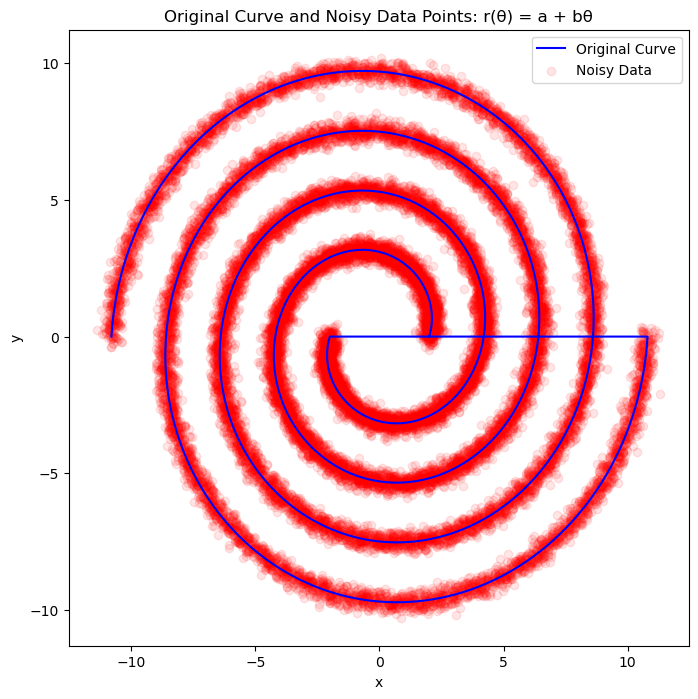

In [2]:
data = GenerateDataset(num_noisy_samples=30)

## 2. Sparse coding

In [3]:
data_tensor = torch.tensor(data, dtype=torch.float32, device = device)

# Create an instance of SparseCoding model
model = SparseCoding(data_size=data_tensor.shape[0], activ_dim=data_tensor.shape[1], basisfunc_num=500, sparsity_level=0)


# Define optimizer for Biasis update
optimizer = optim.Adam([model.Activ, model.Basis], lr=0.01)

# Number of optimization steps
num_epochs = 1000

# Training loop
for epoch in range(num_epochs):

    # Update A
    dist = torch.norm(data_tensor[:, None, :] - model.Basis[None, :, :], p=2, dim=2)
    min_indices = torch.argmin(dist, dim=1)  # Find indices of largest elements in each rowA = model.activ_filtered.detach()

    model.Activ.zero_()
    model.Activ.scatter_(1, min_indices.unsqueeze(1), 1)

    # Update B
    cost = model.loss(data_tensor)
    
    # Zero gradients, perform a backward pass, and update the weights
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Cost = {cost}')

    if cost <= 1e-2:
        print('training ended!')
        break

# After training, you can use the learned dictionary to encode new data
encoded_data = model.Activ @ model.Basis
print("Encoded data shape:", encoded_data.shape)



Epoch [10/1000], Cost = 0.21866486966609955
Epoch [20/1000], Cost = 0.16522571444511414
Epoch [30/1000], Cost = 0.12852473556995392
Epoch [40/1000], Cost = 0.10356312990188599
Epoch [50/1000], Cost = 0.08731381595134735
Epoch [60/1000], Cost = 0.07668524980545044
Epoch [70/1000], Cost = 0.06935161352157593
Epoch [80/1000], Cost = 0.06418722867965698
Epoch [90/1000], Cost = 0.0607578344643116
Epoch [100/1000], Cost = 0.05844002962112427
Epoch [110/1000], Cost = 0.056782692670822144
Epoch [120/1000], Cost = 0.055574931204319
Epoch [130/1000], Cost = 0.0546857975423336
Epoch [140/1000], Cost = 0.05404636636376381
Epoch [150/1000], Cost = 0.053575608879327774
Epoch [160/1000], Cost = 0.05320484936237335
Epoch [170/1000], Cost = 0.05289452150464058
Epoch [180/1000], Cost = 0.05263761430978775
Epoch [190/1000], Cost = 0.05246444791555405
Epoch [200/1000], Cost = 0.05229559913277626
Epoch [210/1000], Cost = 0.052152179181575775
Epoch [220/1000], Cost = 0.05204585939645767
Epoch [230/1000], Co

### Plot learnt dictionary and clustered data points

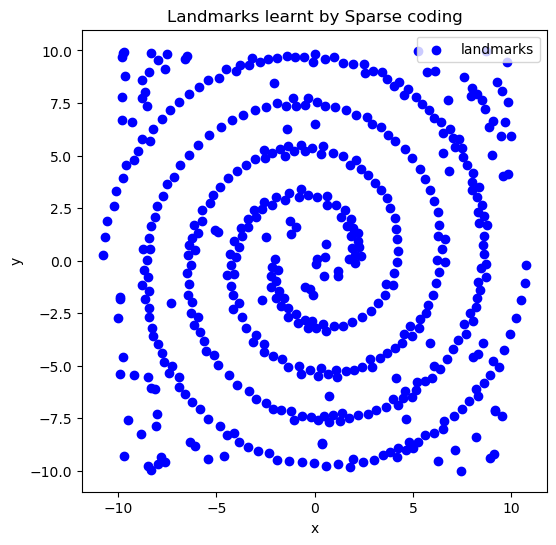

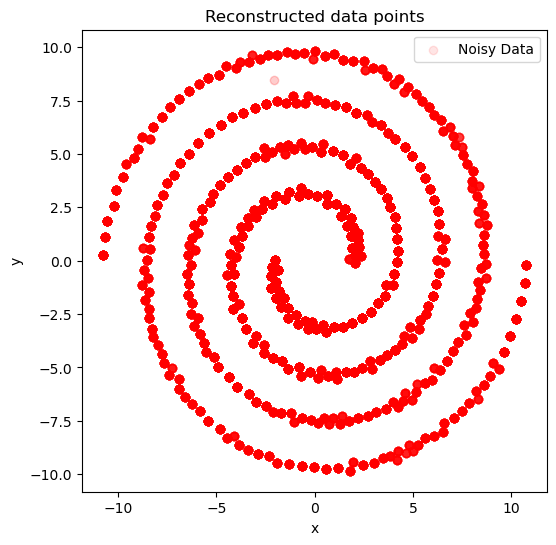

1.0


In [4]:

# return sum_squared_error/num_samples
Bas = model.Basis.detach().cpu()
Act = model.Activ.detach().cpu()

recon = Act @ Bas
# Plotting in polar coordinates

# Original curve label='Original Curve', color='blue')
model.plot_basis()

plt.figure(figsize=[6, 6])

# Noisy data points
ax = plt.subplot(111)
ax.scatter(recon[:, 0], recon[:, 1], label='Noisy Data', color='red', alpha=0.1)

# Setting the title and labels
ax.set_title("Reconstructed data points")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

# Show the plot

print(np.linalg.norm(Act[0,:]))


In [5]:
# Compute a mask indicating whether each basis function is used or not
used_basis_mask = torch.any(Act != 0, dim=0)

print(used_basis_mask.shape)

# Filter out the unused basis functions
model.Basis_filtered = model.Basis.detach()[used_basis_mask,:]
model.Activ_filtered = model.Activ.detach()[:,used_basis_mask]



torch.Size([500])


## 2. Assign similarity (Define D)

### 2.1 K-nearest neighbours in sparse code of data (A)

idx:  6701 / 24000
neighbor idx:  tensor([20302, 13901, 17101, 12301,  8302])
dist:  tensor([0.0412, 0.0482, 0.0569, 0.0866, 0.0883])
tensor([[-8.6207, -0.4838],
        [-8.6306, -0.5092],
        [-8.6154, -0.5475],
        [-8.6623, -0.5361],
        [-8.5000, -0.5311]])


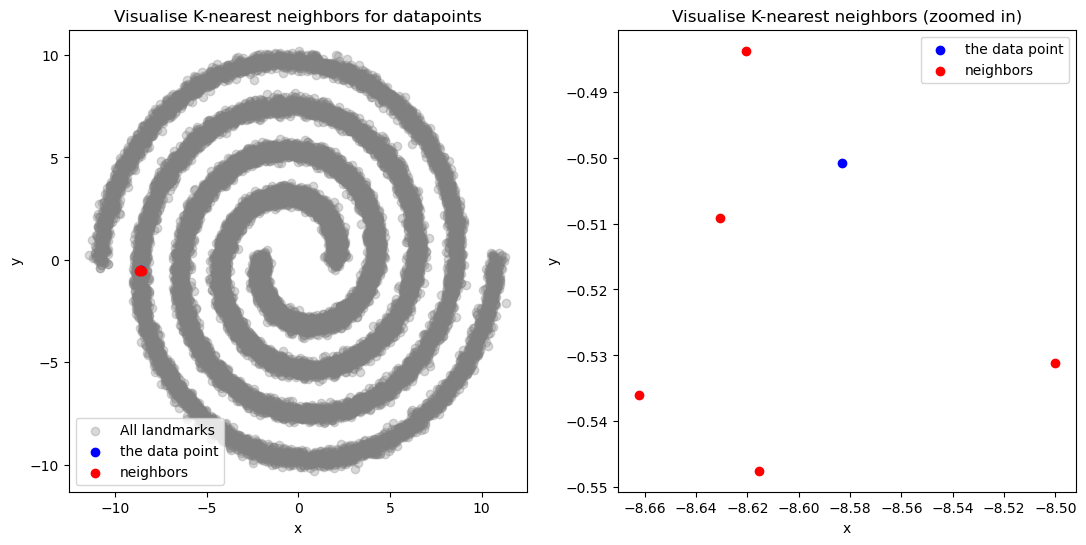

K-nearest neighbors indices of A:
tensor([[16802, 16803, 16001,  7200, 17601],
        [  802,  4003,  9601, 23202, 16004],
        [12003, 13610,  8005,  2401, 21606],
        ...,
        [19996, 10397, 23996, 11196, 18396],
        [ 4796,  1598, 16798, 11998, 15998],
        [ 5599, 22399, 13599, 10399, 17599]])


In [16]:
## Compute K-nearest neighbors for each element in model.Basis

# Compute K-nearest neighbors
neighbors_indices = model.KNN_Data(k=5, data=data_tensor)
print("K-nearest neighbors indices of A:")
print(neighbors_indices)

### 2.2 Construct D from B
Goal: minimising distance between neighbours


### !!Skipped due to dimension issue!!

In [7]:
# a = torch.zeros(7,4,7)
# b = torch.zeros(7,5)

# print((a@b@b.T@a.T).shape)
# # print(a.shape)
# # print(((a@a).shape))

Goal: keep topology by using interpolation (LLE on ~~dictionary~~ dataset elements)

In [17]:
## interpolation Weight matrix
neighbors = data_tensor[neighbors_indices,:] #ss (N,k,2)

print('neighbors shape: ', neighbors.shape)

local_cov = (data_tensor.unsqueeze(1)-neighbors) @ torch.transpose((data_tensor.unsqueeze(1)-neighbors), dim0=1, dim1=2) # (N,k,k)=(N,k,2)@(N,2,k)
local_cov_inv = torch.inverse(local_cov) # (N,k,k)

print(local_cov.shape, ', device =', local_cov.device)
print(local_cov[1]@local_cov_inv[1] - torch.eye(local_cov.shape[1], device=device))

weight = torch.sum(local_cov_inv,dim=1) / torch.sum(torch.sum(local_cov_inv,dim=1),dim=-1).unsqueeze(1) #(N,k)

print('weight: ', weight.unsqueeze(-1).shape)
recon_dataset = torch.transpose(neighbors,dim0=1,dim1=2) @ weight.unsqueeze(-1) # (N,2,k) @ (N,k,1)
recon_dataset.squeeze_(2)
print(recon_dataset.shape)
print('interpolation error =  ')
print(recon_dataset - data_tensor)

# check sum of weight
print(torch.sum(weight,dim=1))


neighbors shape:  torch.Size([24000, 5, 2])
torch.Size([24000, 5, 5]) , device = mps:0
tensor([[  5.0688,  -3.4938,   0.2705,   1.7504,   0.3697],
        [ -3.2444,   2.4555,  -0.6423,  -1.5958,  -0.3806],
        [ -0.6533,   3.5620,  -0.3600,   0.3017,   0.2495],
        [  2.5669, -11.2222,   1.2182,  -2.7783,   0.9392],
        [  0.2565,   4.8928,   0.0764,  -0.9456,   0.2508]], device='mps:0')
weight:  torch.Size([24000, 5, 1])
torch.Size([24000, 2])
interpolation error =  
tensor([[ 0.0000e+00,  0.0000e+00],
        [-2.3842e-07, -1.4901e-08],
        [-2.3842e-07, -2.9802e-08],
        ...,
        [ 0.0000e+00,  0.0000e+00],
        [ 2.8610e-06, -8.9407e-08],
        [ 9.5367e-07,  2.9802e-08]], device='mps:0')
tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='mps:0')


torch.Size([24000, 5])
torch.Size([24000, 5])
tensor([[ 1.2717e+01, -8.3241e-01],
        [-3.6754e+01, -2.7962e+00],
        [ 3.8919e+01,  6.5918e+00],
        ...,
        [ 1.8207e+01, -1.1951e+00],
        [-7.5743e+01,  3.1522e+00],
        [-1.7190e-01, -1.7312e-02]], device='mps:0')


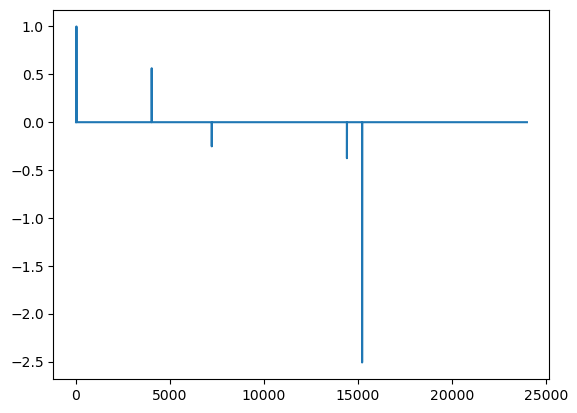

In [18]:
print(neighbors_indices.shape)
print(weight.shape)
Diff = torch.eye(Act.shape[0], device=device) # (N,N)

# Iterate over each column of Diff (for each data point)
for i in range(neighbors_indices.size(0)):
    # Select vaelements from Diff based on indices and apply weights
    if torch.isinf(weight[i]).any().item():
        print('Inf:')
        print(i)
        print(weight[i])
    Diff[neighbors_indices[i],i] -= weight[i]


# Validation 
print(Diff @ data_tensor) # after diff, data should be ~zero
diff = Diff.cpu()[22]
plt.plot(diff)

In [19]:
print('Diff is symmetric?: ', torch.all(torch.eq(Diff-Diff.T, 0)).item())


Diff is symmetric?:  False


In [20]:
# idx = 917
# print(weight[idx])
# print(data_tensor[idx])
# print('neighbors: ')
# print(neighbors[idx])
# print(local_cov_inv.dtype)
# print(local_cov_inv[idx])

# weight_idx = torch.sum(local_cov_inv[idx],dim=0) / torch.sum(local_cov_inv[idx]) #(N,k)

# # Sum along dim=0 and then sum again
# sum1 = torch.sum(torch.sum(local_cov_inv[idx].cpu(), dim=0))

# # Sum without specifying dimension
# sum2 = torch.sum(local_cov_inv[idx].cpu())

# # Sum without specifying dimension (device version)
# sum3 = torch.sum(local_cov_inv[idx])

# # Sum4
# sum4 = torch.sum(torch.sum(local_cov_inv[idx], dim=0),dim=0)


# # Convert to Python floats and print
# print(float(sum1))
# print(float(sum2))
# print(float(sum3))
# print(float(sum4))


# print(local_cov_inv[idx,1,1])
# tensor_np = local_cov_inv[idx,1,1].cpu().numpy()

# # Print the full tensor
# np.set_printoptions(formatter={'float': '{:0.16f}'.format})
# print("Full tensor:", tensor_np)


### 2.3 Solve generalised eigenvalue problem

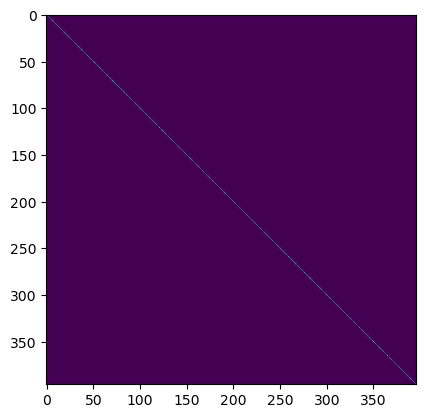

torch.Size([396, 396])
eigns calculated


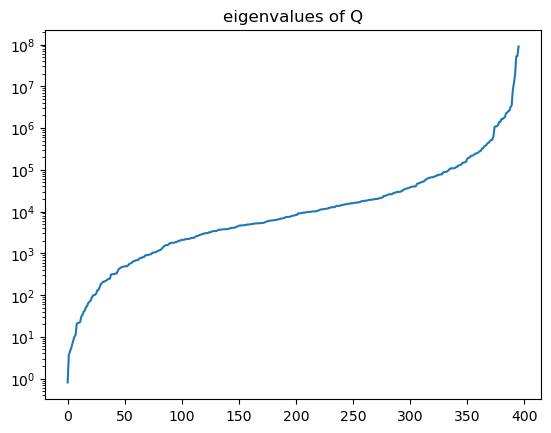

In [54]:
A = model.Activ_filtered.detach()
V = (A.T@A)/A.shape[0]

if device==torch.device("mps"):
    # some operation are not supported on mps device
    V = V.cpu()
    A = A.cpu()
    Diff = Diff.cpu()


#  Compute eigenvalue decomposition of A
V_eigenvalues,V_eigenvectors = torch.linalg.eigh(V, UPLO='U')

# Square root of eigenvalues
V_sqrt_eigenvalues = torch.sqrt(V_eigenvalues)

# Reconstruct square root of A from eigenvalues and eigenvectors
sqrt_V = V_eigenvectors @ torch.diag(V_sqrt_eigenvalues) @ V_eigenvectors.T
inv_sqrt_V = torch.pinverse(sqrt_V)

plt.imshow(V.cpu())
plt.show()

Q = inv_sqrt_V @ A.T @ Diff @ Diff.T @ A @ inv_sqrt_V

print(Q.shape)

Q_eigenvalues, Q_eigenvectors = torch.linalg.eigh(Q, UPLO='U')
print('eigns calculated')

plt.figure()
plt.plot(Q_eigenvalues.cpu())
plt.yscale('log')
plt.title('eigenvalues of Q')
plt.show()


In [63]:
## Now find P
d = 10
P = Q_eigenvectors[:,0:d].T @ inv_sqrt_V



### 2.4 Visualise P

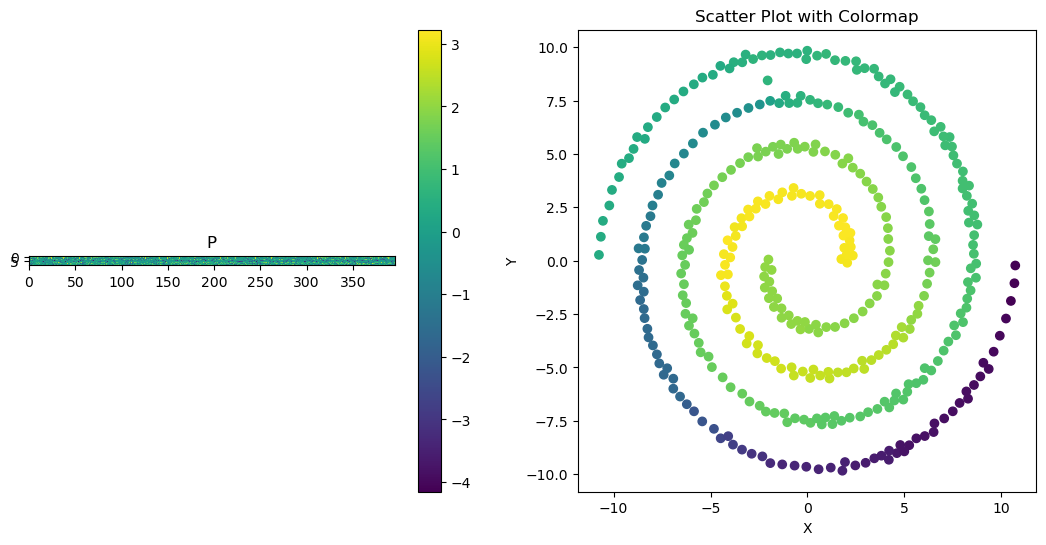

In [64]:
import matplotlib.pyplot as plt

# Example data
idx = 0

# fig, [ax, ax1] = plt.subplots(figsize=[26,12], nrows=1, ncols=2, dpi=1000)
fig, [ax, ax1] = plt.subplots(figsize=[13,6], nrows=1, ncols=2)
# Compute colors for the image
colors = P.cpu()[idx]
colors = (colors - torch.min(colors)) / (torch.max(colors) - torch.min(colors))

cmap = 'viridis'  # Example colormap

# Plot image with colors derived from the colormap
img = ax.imshow(P.cpu(), cmap=cmap)
ax.set_title('P')
fig.colorbar(img, ax=ax)

# Plot scatter points colored with the same colormap
scatter = ax1.scatter(model.Basis_filtered[:, 0].cpu(), model.Basis_filtered[:, 1].cpu(), label='All landmarks', c=colors, cmap=cmap)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Scatter Plot with Colormap')

plt.show()


### 2.5 Embedding space distance visualization

torch.Size([396, 1])


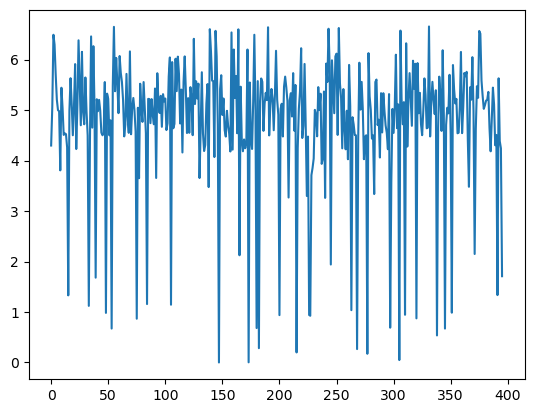

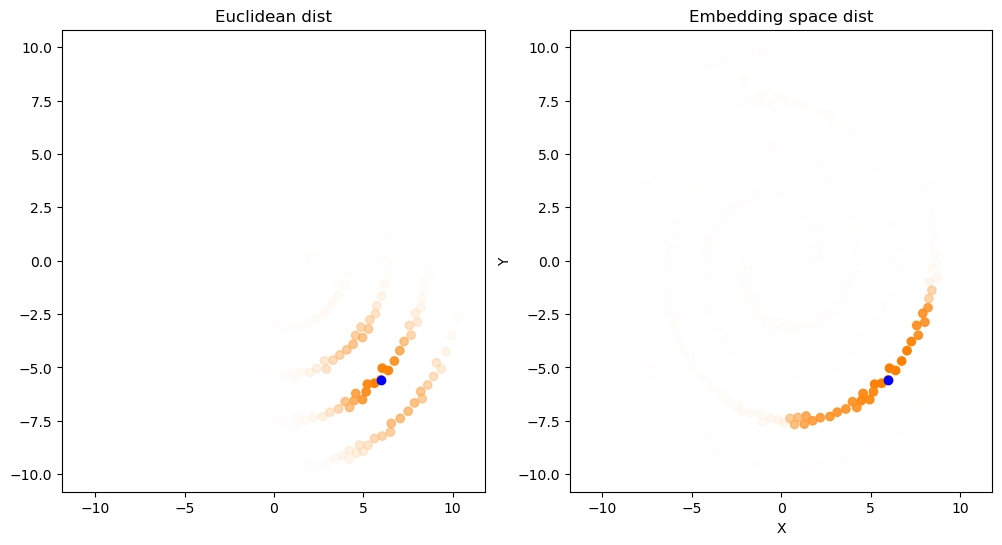

In [76]:

orig_sigma = 2.5
embed_sigma = 2
Bas = model.Basis_filtered.cpu()

landmark_idx = torch.randint(low=0,high=Bas.shape[0],size=(1,)).item()


def gaussian(dist, sigma):
    return torch.exp(-torch.pow(dist, 2) / (2 * sigma**2))

## Euc distance
orig_dist = torch.cdist(Bas,Bas[landmark_idx,:].unsqueeze(0),p=2)
Gaussian_orig_dist = gaussian(orig_dist,sigma=orig_sigma)
print(orig_dist.shape)

## Embedding space dist
embed_dist = torch.cdist(P.T,P.T[landmark_idx,:].unsqueeze(0),p=2)
    # print(embed_dist)
Gaussian_embed_dist = gaussian(embed_dist,sigma=embed_sigma)

plt.plot(embed_dist)
plt.show()

fig, [ax, ax1] = plt.subplots(figsize=[12,6],nrows=1, ncols=2)

map = [(1, 1, 1, 0), (1, 0.5, 0, 1)]  # Start with transparent (white) and end with orange
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', map)

# plot dictionary elements using first row of P


ax.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=Gaussian_orig_dist.cpu(), cmap=cmap,vmin=1e-2, vmax=1)
ax1.scatter(Bas[:, 0], Bas[:, 1], label='All landmarks', c=Gaussian_embed_dist.cpu(), cmap=cmap,vmin=1e-2, vmax=1)

ax.scatter(Bas[landmark_idx, 0], Bas[landmark_idx, 1], label='the landmark', c='blue')
ax1.scatter(Bas[landmark_idx, 0], Bas[landmark_idx, 1], label='the landmark', c='blue')

plt.xlabel('X')
plt.ylabel('Y')
ax.set_title('Euclidean dist')
ax1.set_title('Embedding space dist')

plt.show()
